# [13주차] 딥러닝이 세상을 바꾼 이유: 고차원 이미지 분류 📸

안녕하세요! 13주차 수업에 오신 것을 환영합니다.  
지난 시간까지 우리는 비교적 적은 숫자, 몇 개의 특징(Feature)을 가진  
붓꽃(Iris), 와인(Wine) 같은 데이터를 다루었습니다.

오늘은 딥러닝이 왜 세상을 바꾸었는지, 그 강력함을 체감하는 시간입니다.  
우리는 **고차원(High-Dimensional)** 데이터의 대표 주자인 **이미지 데이터**를 다룰 것입니다.

**Fashion-MNIST** 데이터셋을 사용하여,  
단순한 선형 모델(로지스틱 회귀)과 딥러닝 모델(MLP)의 성능을 비교해 봅니다.  
**"왜 딥러닝이 강력한가?"** 에 대한 답을 오늘 직접 찾아보겠습니다.

## 🖼️ 모듈 1: 이미지 데이터는 '숫자'다

**Fashion-MNIST 데이터셋이란?**  
- 10가지 종류의 패션 아이템 (티셔츠, 바지, 신발, 가방 등) 이미지로 구성된  
  유명한 머신러닝 '공개 데이터셋'입니다.  
- 총 70,000개의 흑백 이미지 (연습 60,000개, 시험 10,000개)
- 각 이미지는 **가로 28픽셀 x 세로 28픽셀** 크기입니다.
<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*fQiUzijdHlukruf9akgH2Q.png" width="600"/>

**어떻게 이미지를 '데이터'로 다룰까요?**
- 흑백 이미지는 각 픽셀마다 0(검은색)부터 255(흰색)까지의 밝기 값을 가집니다.
- **28 x 28 = 784**
- 즉, 하나의 이미지는 **784개의 숫자**로 이루어진 **1차원 벡터(Vector)** 로 표현할 수 있습니다!
- 우리의 모델은 이 784개의 특징(Feature)을 보고 10가지 아이템 중 하나로 분류해야 합니다.

### [1단계] 데이터 준비 및 탐색

`scikit-learn`은 `load_` 함수 외에도,  
`fetch_openml` 함수를 통해 더 크고 다양한 온라인 데이터셋을 불러올 수 있습니다.

In [1]:
# 필요한 라이브러리 임포트
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml # OpenML 데이터셋 로드
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression # 비교용 선형 모델
from sklearn.neural_network import MLPClassifier # 딥러닝 모델
from sklearn.preprocessing import StandardScaler # 스케일링
from sklearn.metrics import accuracy_score, classification_report

# 1. Fashion-MNIST 데이터 로드
# fetch_openml: OpenML.org에서 데이터셋을 이름으로 불러옵니다.
# name='Fashion-MNIST': 데이터셋 이름
# version=1: 데이터셋 버전
# as_frame=False: Pandas DataFrame이 아닌 NumPy 배열로 받기
# parser='auto': (최신 scikit-learn 권장 사항)
fashion_mnist = fetch_openml('Fashion-MNIST', version=1,
                    as_frame=False, parser='auto')
X, y = fashion_mnist.data, fashion_mnist.target

print("데이터 로드 완료!")
# X는 (70000, 784) shape, y는 (70000,) shape
print(f"X (이미지 데이터) Shape: {X.shape}")
print(f"y (정답 레이블) Shape: {y.shape}")

# y의 레이블 확인 (문자열 '0' ~ '9'로 되어 있음)
print(f"\n레이블 종류 (원본): {np.unique(y)}")
# 모델 학습을 위해 y를 문자열에서 정수형으로 변환
y = y.astype(int)
print(f"레이블 종류 (정수형): {np.unique(y)}")

데이터 로드 완료!
X (이미지 데이터) Shape: (70000, 784)
y (정답 레이블) Shape: (70000,)

레이블 종류 (원본): ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
레이블 종류 (정수형): [0 1 2 3 4 5 6 7 8 9]


`X`에 저장된 784개의 숫자가 정말 이미지인지  
데이터 하나를 뽑아 시각화해 봅시다.

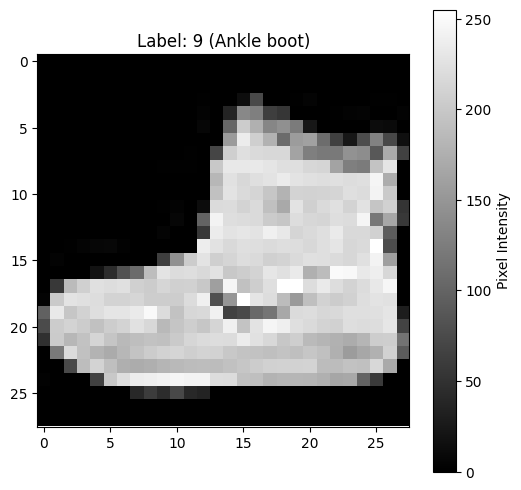

X[0]의 Shape: (784,)
first_image의 Shape: (28, 28)


In [2]:
# X에서 첫 번째 이미지 데이터(784개 숫자)를 선택
first_image_data = X[0]
# 784개의 1차원 벡터를 28x28의 2차원 행렬로 변환
first_image = first_image_data.reshape(28, 28)

# 10가지 클래스의 이름 정의
class_names = ["T-shirt/top", "Trouser", "Pullover",
               "Dress", "Coat", "Sandal", "Shirt",
               "Sneaker", "Bag", "Ankle boot"]

# plt.imshow() : 2D 배열을 이미지로 시각화
plt.figure(figsize=(6, 6))
# cmap='gray': 흑백(grayscale) 컬러맵 사용
plt.imshow(first_image, cmap='gray')
plt.title(f"Label: {y[0]} ({class_names[y[0]]})")
plt.colorbar(label="Pixel Intensity")
plt.show()

print(f"X[0]의 Shape: {first_image_data.shape}")
print(f"first_image의 Shape: {first_image.shape}")

## 모듈 2: 데이터 전처리 및 기준 모델 (Logistic Regression)
### [2단계] 데이터 스케일링 및 분리

**1. 스케일링 (Scaling)**
- 현재 픽셀 값은 0\~255 범위입니다.
- MLP와 같은 신경망 모델은 입력값의 스케일에 민감합니다.
- 0\~255 범위를 0\~1 범위로 정규화(Normalization)하면  
  학습이 훨씬 빠르고 안정적으로 진행됩니다.
- **방법**: 모든 픽셀 값을 255.0으로 나누어줍니다.

**2. 데이터 분리**
- Fashion-MNIST는 관례적으로  
60,000개를 연습(Train), 10,000개를 시험(Test)용으로 사용합니다.
- `train_test_split`

In [3]:
# 1. 스케일링 (0-1 Normalization)
# 픽셀 최대값인 255.0으로 나누어 0~1 범위로 만듭니다.
X_scaled = X / 255.0

# 스케일링 결과 확인
print(f"스케일링 전 (Min: {X.min()}, Max: {X.max()})")
print(f"스케일링 후 (Min: {X_scaled.min()}, Max: {X_scaled.max()})")

# 2. 데이터 분리
# Test size를 10000개로, Train size를 60000개로 설정
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=10000, random_state=42, stratify=y
)

print(f"\nTrain 데이터 Shape: {X_train.shape}")
print(f"Test 데이터 Shape: {X_test.shape}")

스케일링 전 (Min: 0, Max: 255)
스케일링 후 (Min: 0.0, Max: 1.0)

Train 데이터 Shape: (60000, 784)
Test 데이터 Shape: (10000, 784)


### [3단계] 기준 모델 (Baseline) 학습: 로지스틱 회귀

딥러닝 모델이 얼마나 좋은지 알려면,  
**비교 대상(Baseline)** 이 필요합니다.

여기서는 784개의 픽셀 값을 입력받아 10개 클래스를 분류하는  
**로지스틱 회귀** 모델을 기준 모델로 사용해 보겠습니다.

In [5]:
# 1. 로지스틱 회귀 모델 생성 및 학습
# solver='saga'
# max_iter=30 : 대용량 데이터이므로 반복 횟수 설정 (시간 관계상 30회)
print("로지스틱 회귀 모델 학습 시작... (몇 분 정도 소요될 수 있습니다)")
model_lr = LogisticRegression(
    solver='saga',
    max_iter=30, # 실제로는 더 많이 필요할 수 있음
    random_state=42
)
model_lr.fit(X_train, y_train)

# 2. 성능 평가
y_pred_lr = model_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

print("\n--- 로지스틱 회귀 성능 평가 (Test Data) ---")
print(f"정확도: {accuracy_lr:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr,
                            target_names=class_names))

로지스틱 회귀 모델 학습 시작... (몇 분 정도 소요될 수 있습니다)

--- 로지스틱 회귀 성능 평가 (Test Data) ---
정확도: 0.8546

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.78      0.84      0.81      1000
     Trouser       0.98      0.96      0.97      1000
    Pullover       0.76      0.74      0.75      1000
       Dress       0.84      0.85      0.84      1000
        Coat       0.74      0.82      0.78      1000
      Sandal       0.95      0.94      0.95      1000
       Shirt       0.65      0.56      0.60      1000
     Sneaker       0.93      0.93      0.93      1000
         Bag       0.96      0.95      0.96      1000
  Ankle boot       0.95      0.95      0.95      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## 🚀 모듈 3: MLP로 고차원 이미지 분류하기

### [4단계] 딥러닝 모델(MLP) 학습 및 평가

이제 동일한 데이터를 **MLP**로 학습시켜 보겠습니다.  
MLP는 784개의 픽셀을 입력받아,  
은닉층에서 이 픽셀들의 **복잡한 조합(패턴)** 을 학습합니다.

In [7]:
# 1. MLP 모델 생성
# hidden_layer_sizes=(200, 100, 50, 10): 200개, 100개, 50개, 10개 뉴런의 4개 은닉층
# 이 구조가 784개의 픽셀 조합(패턴)을 학습합니다.
print("MLP 모델 학습 시작... (시간이 더 오래 걸릴 수 있습니다)")
model_mlp = MLPClassifier(
    hidden_layer_sizes=(200, 100, 50, 10),
    activation='relu',
    max_iter=30,
    random_state=42,
    solver='adam'
)

# 2. 모델 학습
model_mlp.fit(X_train, y_train)

# 3. 성능 평가
y_pred_mlp = model_mlp.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)

print("\n--- MLPClassifier 성능 평가 (Test Data) ---")
print(f"정확도: {accuracy_mlp:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_mlp,
                            target_names=class_names))

MLP 모델 학습 시작... (시간이 더 오래 걸릴 수 있습니다)

--- MLPClassifier 성능 평가 (Test Data) ---
정확도: 0.8947

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.88      0.86      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.82      0.81      0.81      1000
       Dress       0.91      0.91      0.91      1000
        Coat       0.85      0.79      0.82      1000
      Sandal       0.97      0.95      0.96      1000
       Shirt       0.70      0.75      0.72      1000
     Sneaker       0.94      0.95      0.95      1000
         Bag       0.96      0.98      0.97      1000
  Ankle boot       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.90     10000
weighted avg       0.90      0.89      0.90     10000



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


### [5단계] 결과 비교 및 시각화

기준 모델(로지스틱 회귀)과 MLP의 성능을 비교해보고,  
모델이 무엇을 헷갈려하는지 직접 확인해 봅시다.

--- 최종 성능 비교 ---
로지스틱 회귀 (선형 모델) 정확도: 0.8546
MLP (딥러닝 모델) 정확도: 0.8947

성능 향상: 0.0401

=> MLP가 은닉층을 통해 '스스로' 픽셀 패턴을 학습하여
   단순 선형 모델보다 훨씬 높은 성능을 달성했습니다!


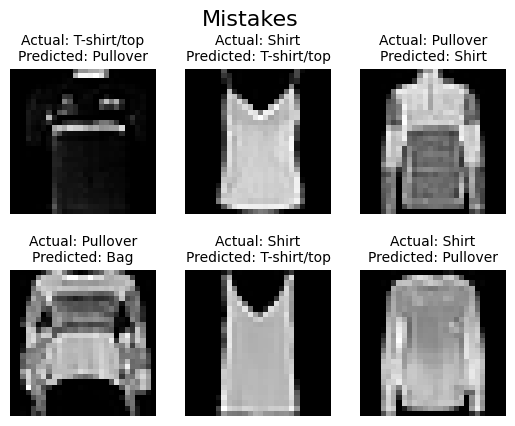


=> 사람이 보기에도 헷갈릴 만한 이미지들(e.g., Pullover/Shirt/Coat)


In [8]:
# 1. 성능 비교
print("--- 최종 성능 비교 ---")
print(f"로지스틱 회귀 (선형 모델) 정확도: {accuracy_lr:.4f}")
print(f"MLP (딥러닝 모델) 정확도: {accuracy_mlp:.4f}")
print(f"\n성능 향상: {accuracy_mlp - accuracy_lr:.4f}")
print("\n=> MLP가 은닉층을 통해 '스스로' 픽셀 패턴을 학습하여")
print("   단순 선형 모델보다 훨씬 높은 성능을 달성했습니다!")


# 2. MLP가 틀린 예측 시각화
# y_test와 y_pred_mlp가 다른 인덱스를 찾습니다.
misclassified_indices = np.where(y_test != y_pred_mlp)[0]

# 틀린 예측 중 6개를 무작위로 선택
plt.figure()
for i, idx in enumerate(np.random.choice(misclassified_indices,
                                         6, replace=False)):
    plt.subplot(2, 3, i + 1)
    # X_test는 스케일링된 상태이므로, 시각화를 위해 원래 픽셀값(0~255)으로
    # 되돌리기 위해 255를 곱합니다.
    image = (X_test[idx] * 255.0).reshape(28, 28)
    plt.imshow(image, cmap='gray')

    actual_label = class_names[y_test[idx]]
    predicted_label = class_names[y_pred_mlp[idx]]

    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}",
              fontsize=10)
    plt.axis('off')

plt.suptitle("Mistakes", fontsize=16)
plt.show()

print("\n=> 사람이 보기에도 헷갈릴 만한 이미지들(e.g., Pullover/Shirt/Coat)")

## 💡 [보충 설명] "CNN이 겨울을 깼는데, 왜 MLP가 잘 되나요?"

2주차 역사 강의에서 'AI 겨울'을 언급했습니다.  
(정확히는 1990년대의 '두 번째 AI 겨울'입니다.)  
그리고 2012년 'AlexNet' (CNN의 일종)이 이 겨울을 깼다고 배웠습니다.

그런데 왜 오늘, CNN이 아닌 MLP를 사용했는데도  
784차원의 복잡한 이미지 데이터에서,  
88%가 넘는 (선형 모델을 압도하는) 좋은 성능이 나온 것일까요?

---

이 질문은 딥러닝의 핵심을 짚고 있습니다.

과거 90년대의 MLP가 실패했던 가장 큰 기술적 원인은  
**'기울기 소실(Vanishing Gradient)'** 문제 때문이었습니다.  
모델의 층이 깊어질수록(Deep),  
학습 신호(Gradient)가 역전파 과정에서 0에 가깝게 사라져  
앞쪽 층의 뉴런들이 전혀 학습되지 못했습니다.

이는 당시 사용하던 'Sigmoid' 활성화 함수의 수학적 한계였습니다.

---

2012년 AlexNet(CNN)이 이 겨울을 깬 비결은,  
물론 CNN의 뛰어난 구조(공간 정보 학습)도 있었지만,  
그것과 함께 **AI 겨울을 근본적으로 해결한 핵심 기술들**을 사용했기 때문입니다:

1.  **ReLU 활성화 함수**: Sigmoid 대신 ReLU를 사용하여 기울기 소실을 해결.
2.  **GPU 병렬 처리**: 대규모 연산을 빠르게 처리.
3.  **대용량 데이터**: 'ImageNet' 같은 충분한 학습 데이터.

---

**오늘 우리가 사용한 MLP는 90년대의 MLP가 아닙니다.**  
우리의 `MLPClassifier`도 AI 겨울을 깬 핵심 기술들을 동일하게 사용했습니다.

-   `activation='relu'`: 기울기 소실을 해결한 **ReLU**를 사용했습니다.
-   `solver='adam'`: 기울기를 효율적으로 관리하는 **최신 최적화 알고리즘**을 사용했습니다.
-   우리는 Fashion-MNIST라는 **대용량 데이터**를 사용했습니다.

즉, MLP 역시 **'깊게(Deep)' 쌓아도 학습이 가능하도록** 기술적 토대가 마련되었기 때문에,  
784개의 픽셀 입력을 받고도 은닉층에서 복잡한 패턴을 스스로 학습할 수 있었던 것입니다.

##  🧠 모듈 4: 진짜 이미지 전문가, CNN 맛보기 (PyTorch)

**CNN (Convolutional Neural Network)**  
MLP가 선형 모델보다 훨씬 뛰어난 성능을 보였지만,  
여전히 이미지 분류에 최적화된 모델은 아닙니다.

**MLP의 근본적인 한계**:
- **공간 정보(Spatial Information)의 손실**:
  - MLP는 이미지를 `(784,)` 형태의 **1차원 벡터**로 입력받습니다.
  - 이 과정에서 픽셀의 **2차원 공간 정보(위/아래/좌/우 관계)** 가 사라집니다.
  - 모델은 (0,0) 픽셀과 (0,1) 픽셀이 가깝다는 사실을 모릅니다.
- **비효율적인 학습 (Parameter Inefficiency)**:
  - 앵클 부츠의 '굽'이 이미지의 **왼쪽 아래**에 있을 때의 패턴과,  
    **오른쪽 아래**에 있을 때의 패턴을 **따로따로** 학습해야 합니다.
  - "굽"이라는 동일한 특징을 위치마다 새로 배워야 하므로 매우 비효율적입니다.

**CNN (합성곱 신경망)의 아이디어**:
- CNN은 이미지를 1차원으로 펴지 않고, **2차원(28x28) 그대로** 입력받습니다.
- **핵심 아이디어**: "특징(e.g., 선, 코너, 굽)"을 감지하는 작은 **'필터(Filter)'** (e.g., 3x3)를  
  마치 **돋보기나 스캐너**처럼 이미지 전체에 **슬라이딩(Sliding)** 시킵니다.
- **Convolution (합성곱 연산)**: 이 필터가 이미지의 특정 영역과 겹쳐져서  
  해당 영역이 필터의 패턴과 얼마나 일치하는지 계산합니다.

**CNN이 강력한 이유**:
1.  **공간 정보 유지**: 2D 구조를 그대로 사용하므로 픽셀 간의 이웃 관계를 학습합니다.
2.  **파라미터 공유 (Parameter Sharing)**: **'하나'의 필터**로 이미지 **'전체'** 를 스캔합니다.  
    - '굽' 특징을 감지하는 필터를 한 번만 학습하면,  
      그 굽이 이미지의 왼쪽에 있든 오른쪽에 있든 동일한 필터로 감지할 수 있습니다.
    - 이는 MLP 대비 학습할 파라미터 수를 획기적으로 줄여,  
    훨씬 효율적이고 강력한 학습을 가능하게 합니다.

CNN은 (합성곱 계층 + 풀링 계층)을 여러 겹 쌓아,  
처음에는 **단순한 선/모양**을 학습하고, 뒤로 갈수록 이들이 조합된  
**더 복잡하고 추상적인 특징**(e.g., 눈, 코, 바퀴)을 학습합니다.  
이것이 2012년 AlexNet이 AI 겨울을 깬 비결입니다.

### [참고] PyTorch를 이용한 CNN 구현 예시

`scikit-learn`은 CNN을 지원하지 않습니다.  
`PyTorch`나 `TensorFlow` 같은 딥러닝 전문 라이브러리가 필요합니다.

아래는 `PyTorch`를 사용한 간단한 CNN 모델 구현 예시입니다.  
(실행 시간이 몇 분 이상 걸릴 수 있습니다.)

**단, 지금 이 코드를 완벽히 이해할 필요는 없습니다.**  
MLP와 결과(정확도)가 얼마나 차이 나는지만 '납득'하는 것이 목표입니다.  
특히 `class SimpleCNN(nn.Module):` 부분의 구조에 주목해 보세요.

In [10]:
# PyTorch 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 1. 데이터 형태 변환 (PyTorch Tensor용)
# NumPy 배열을 PyTorch 텐서로 변환
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.LongTensor(y_train) # 분류의 정답은 LongTensor
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# CNN은 (샘플 수, 채널 수, 높이, 너비)의 4D 입력을 요구합니다.
# (60000, 784) -> (60000, 1, 28, 28) (1은 흑백 채널)
X_train_cnn = X_train_tensor.reshape(-1, 1, 28, 28)
X_test_cnn = X_test_tensor.reshape(-1, 1, 28, 28)

# DataLoader: 데이터를 미니배치(minibatch)로 묶어주는 유틸리티
train_dataset = TensorDataset(X_train_cnn, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test_cnn, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# 2. CNN 모델 정의 (PyTorch nn.Module)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 1. Convolution Layer: 1개의 흑백 채널을 입력받아,
        #     16개의 '스캐너'로 28x28 이미지 스캔
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16,
                               kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        # 2. MaxPooling Layer: 2x2 영역에서 가장 강한 특징만 뽑아,
        #     이미지 크기 축소 (28x28 -> 14x14)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 3. Flatten Layer: 2D 특징 맵 -> 1D 벡터로 변환 (MLP 입력을 위해)
        self.flatten = nn.Flatten()
        # 4. Dense Layer (MLP): 16*14*14 크기의 벡터를 128개 뉴런으로 압축
        self.fc1 = nn.Linear(16 * 14 * 14, 128)
        # 5. Output Layer (MLP): 128개 뉴런을 10개 클래스(0~9)로 최종 분류
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # 데이터의 흐름 정의
        x = self.pool(self.relu(self.conv1(x))) # Conv -> ReLU -> Pool
        x = self.flatten(x)                     # Flatten
        x = self.relu(self.fc1(x))            # Dense -> ReLU
        x = self.fc2(x)                         # Output
        return x

model_cnn = SimpleCNN()
criterion = nn.CrossEntropyLoss() # 다중 분류용 비용 함수
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001) # 최적화 알고리즘

# 3. 모델 학습 (시간 관계상 10 Epochs만 반복)
print("\nPyTorch CNN 모델 학습 시작...")
model_cnn.train() # 모델을 학습 모드로 설정
for epoch in range(10): # 전체 데이터셋을 10번 반복 학습
    for inputs, labels in train_loader:
        optimizer.zero_grad() # 기울기 초기화
        outputs = model_cnn(inputs) # 순전파
        loss = criterion(outputs, labels) # 오차 계산
        loss.backward() # 역전파
        optimizer.step() # 가중치 업데이트
    print(f"Epoch {epoch+1}/10, Loss: {loss.item():.4f}")

# 4. 모델 평가
model_cnn.eval() # 모델을 평가 모드로 설정
correct = 0
total = 0
with torch.no_grad(): # 기울기 계산 비활성화
    for inputs, labels in test_loader:
        outputs = model_cnn(inputs)
        _, predicted = torch.max(outputs.data, 1) # 가장 확률이 높은 클래스 선택
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy_cnn = correct / total
print(f"\n--- CNN 성능 평가 (Test Data) ---")
print(f"정확도: {accuracy_cnn:.4f}")

# 5. 최종 성능 비교
print("\n--- 최종 성능 비교 ---")
print(f"로지스틱 회귀 (선형 모델) 정확도: {accuracy_lr:.4f}")
print(f"MLP (딥러닝 모델) 정확도: {accuracy_mlp:.4f}")
print(f"CNN (딥러닝 전문가) 정확도: {accuracy_cnn:.4f}")
print("\n=> CNN이 이미지의 '공간 정보'와 '패턴'을 훨씬 효율적으로 학습하여")
print("   MLP보다 더 높은 성능을 달성했습니다!")


PyTorch CNN 모델 학습 시작...
Epoch 1/10, Loss: 0.3730
Epoch 2/10, Loss: 0.2957
Epoch 3/10, Loss: 0.3789
Epoch 4/10, Loss: 0.3020
Epoch 5/10, Loss: 0.2208
Epoch 6/10, Loss: 0.0739
Epoch 7/10, Loss: 0.0374
Epoch 8/10, Loss: 0.0779
Epoch 9/10, Loss: 0.1845
Epoch 10/10, Loss: 0.0245

--- CNN 성능 평가 (Test Data) ---
정확도: 0.9189

--- 최종 성능 비교 ---
로지스틱 회귀 (선형 모델) 정확도: 0.8546
MLP (딥러닝 모델) 정확도: 0.8947
CNN (딥러닝 전문가) 정확도: 0.9189

=> CNN이 이미지의 '공간 정보'와 '패턴'을 훨씬 효율적으로 학습하여
   MLP보다 더 높은 성능을 달성했습니다!


## ✨ 마무리

오늘은 784차원이라는 고차원 이미지 데이터를 다루어 보았습니다.

- **선형 모델의 한계**: 로지스틱 회귀는 픽셀의 복잡한 조합을 학습하지 못해 낮은 성능(약 85%)을 보였습니다.
- **MLP의 강력함**: MLP는 **'은닉층'** 과 **'비선형 활성화(ReLU)'** 를 통해,  
  데이터로부터 **'스스로'** 특징(패턴)을 학습하여 더 높은 성능(약 89%)을 달성했습니다.
- **CNN의 전문성**: MLP는 픽셀의 **'공간 정보'** 를 잃어버리는 한계가 있었지만,  
  **'합성곱(Convolution)'** 연산을 사용하는 CNN은 이 공간 정보를 활용하여  
  이미지 인식에 훨씬 더 강력한 성능(약 92%)을 보여주었습니다.

이것이 딥러닝, 특히 CNN이 AI 겨울을 깨고 이미지/음성 인식 분야를 혁신한 이유입니다.

다음 시간에는 이 모든 과정을 총망라하는 **최종 기말 프로젝트**를 진행하겠습니다.

```

































```



































